<a href="https://colab.research.google.com/github/37stu37/FFE/blob/master/FFE_network_w_Dack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%time 
%%capture
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes

CPU times: user 198 ms, sys: 43.5 ms, total: 242 ms
Wall time: 22.8 s


In [2]:
# Load the Drive helper and mount
from google.colab import drive
%tensorflow_version 2.x
# This will prompt for authorization.
drive.mount('/content/drive')

TensorFlow 2.x selected.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
%%time
import datetime
import glob
import math
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.spatial import distance
from shapely.geometry import box
from shapely.geometry import shape
from shapely.geometry import Point
import networkx as nx
from sys import getsizeof
from numba import jit
import dask.dataframe as dd
import dask.array as da
import dask_distance
import dask
from dask.distributed import Client
%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

CPU times: user 2.12 ms, sys: 10 µs, total: 2.13 ms
Wall time: 2.01 ms


In [4]:
client = Client(processes=False)
client

/usr/local/lib/python3.6/dist-packages/distributed/bokeh/core.py:57: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 99] Cannot assign requested address
  warnings.warn('\n' + msg)
/usr/local/lib/python3.6/dist-packages/distributed/deploy/local.py:197: UserWarning: 
Could not launch service 'bokeh' on port 8787. Got the following message:

[Errno 99] Cannot assign requested address
  self.scheduler.start(scheduler_address)


Client Scheduler: inproc://172.28.0.2/22258/1,Cluster Workers: 1 Cores: 4 Memory: 27.40 GB


In [5]:
path = '/content/drive/My Drive/05_Sync/FFE/FireNetwork/00_input'
path_output = '/content/drive/My Drive/05_Sync/FFE/FireNetwork/00_output'

!ls "/content/drive/My Drive/05_Sync/FFE/FireNetwork/00_input"

buildings_raw.cpg      buildings_raw_pts.mshp  buildings_raw.shp
buildings_raw.dbf      buildings_raw_pts.prj   buildings_raw.shx
buildings_raw.prj      buildings_raw_pts.shp   GD_wind.csv
buildings_raw_pts.cpg  buildings_raw_pts.shx
buildings_raw_pts.dbf  buildings_raw.qpj


In [0]:
def load_data(file_name, minx, miny, maxx, maxy):
    # crop data
    bbox = box(minx, miny, maxx, maxy)
    # building point dataset
    gdf_buildings = gpd.read_file(os.path.join(path, file_name), bbox=bbox)
    gdf_buildings['X'] = gdf_buildings.geometry.centroid.x
    gdf_buildings['Y'] = gdf_buildings.geometry.centroid.y

    # print(gdf_buildings.dtypes)
    max_extent = gdf_buildings.total_bounds
    data_size = getsizeof(gdf_buildings)/(1024.0**3)
    print("Shapefile extent : {}".format(max_extent))
    print("Asset loaded : {}".format(len(gdf_buildings)))
    print("Data size:{} GB'".format(data_size))
    # gdf_buildings.IgnProb_bl = 0.02
    # xmin,ymin,xmax,ymax = gdf_buildings.total_bounds

    # Precision of float32 is sufficient for lat and lon
    float_columns = ['SHAPE_Leng','SHAPE_Area',
                    'IgnProb_bl','RandProb']
    gdf_buildings[float_columns] = gdf_buildings[float_columns].astype('float32')
    int_columns = ['TARGET_FID','Combustibl',
                    'AU2013Num','RandProb']
    gdf_buildings[int_columns] = gdf_buildings[int_columns].astype('int32')
    data_size = getsizeof(gdf_buildings)/(1024.0**3)
    print("resized Data size:{} GB'".format(data_size))

    return gdf_buildings


def wind_scenario():
    wind_data = pd.read_csv(os.path.join(path, 'GD_wind.csv'))
    i = np.random.randint(0, wind_data.shape[0])
    w = wind_data.iloc[i, 2]
    d = wind_data.iloc[i, 1]
    b = wind_data.iloc[i, 3]
    return w, d, b


def create_network(edge_list_dataframe):
    graph = nx.from_pandas_edgelist(edge_list_dataframe, edge_attr=True)
    # options = {'node_color': 'red', 'node_size': 50, 'width': 1, 'alpha': 0.4,
    #            'with_labels': False, 'font_weight': 'bold'}
    # nx.draw_kamada_kawai(graph, **options)
    # plt.show()
    return graph

In [0]:
def set_initial_fire_to(df):
    """Fine = 0, Fire = 1, Burned = 2"""
    df['RNG'] = np.random.uniform(0, 1, size=len(df))  # add for random suppression per building, df.shape[0])
    onFire = df['source_IgnProb_bl'] > df['RNG']
    ignitions = df[onFire]
    # source nodes ignited
    sources_on_fire = list(ignitions.source)
    sources_on_fire = list(dict.fromkeys(sources_on_fire))
    return sources_on_fire


def set_fire_to(df, existing_fires):
    are_set_on_fire = (df['source'].isin(existing_fires))
    spark = df[are_set_on_fire]
    # source nodes ignited
    sources_on_fire = list(spark.source)
    sources_on_fire = list(dict.fromkeys(sources_on_fire))
    return sources_on_fire


def fire_spreading(list_fires, list_burn, wind_speed, wind_bearing, suppression_threshold, step_value, data):
    # check the fire potential targets
    # print("fire list before spreading : {}, length : {}".format(list_fires, len(list_fires)))
    are_potential_targets = (data['source'].isin(list_fires))
    are_not_already_burned = (~data['target'].isin(list_burn))
    df = data[are_potential_targets & are_not_already_burned]
    if df.empty:
        # print("no fires")
        list_burn.extend(list(list_fires))
        list_burn = list(dict.fromkeys(list_burn))
        return [], list_burn  # to break the step loop
    # set up additional CONDITIONS for fire spreading

    # neighbors selection from buffer
    are_neighbors = df['distance'] < wind_speed
    df = df[are_neighbors]

    # wind direction
    wind_bearing_max = wind_bearing + 45
    wind_bearing_min = wind_bearing - 45
    if wind_bearing == 360:
        wind_bearing_max = 45
    if wind_bearing <= 0:  # should not be necessary
        wind_bearing_min = 0
    if wind_bearing == 999:
        wind_bearing_max = 999
        wind_bearing_min = 0
    are_under_the_wind = (df['bearing'] < wind_bearing_max) & (df['bearing'] > wind_bearing_min)
    # print("targets under the wind ? {}".format(list(dict.fromkeys(list(are_under_the_wind)))))
    df = df[are_under_the_wind]
    # suppression
    df['random'] = np.random.uniform(0, 1, size=len(df))
    are_not_suppressed = df['random'] > suppression_threshold
    # print("fire suppressed ? {}".format(list(dict.fromkeys(list(are_not_suppressed)))))
    df = df[are_not_suppressed]

    # spread fire based on condition
    fire_df = df
    # fire_df = df[are_neighbors & are_under_the_wind & are_not_suppressed]  # issues with "are_under_the_wind
    # print(len(fire_df.head(5)))
    # print(len(fire_df))
    list_burn.extend(list(list_fires))
    fire_df['step'] = step_value
    # fire_df.to_csv(os.path.join(path_output, "step{}_fire.csv".format(step_value))) # ADD IF CSV OUTPUT NEEDED
    list_fires = list(dict.fromkeys(list(fire_df.target)))
    list_burn.extend(list(fire_df.target))
    list_burn = list(dict.fromkeys(list_burn))
    return list_fires, list_burn


def log_files_concatenate(prefix, scenario_count):
    list_df = []
    files = glob.glob(os.path.join(path_output, prefix))
    if files:
        for file in files:
            # print(file)
            df = pd.read_csv(os.path.join(path_output, file))
            list_df.append(df)
            os.remove(file)
        data = pd.concat(list_df)
        data['scenario'] = scenario_count
        data.to_csv(os.path.join(path_output, "fire_scenario_{}.csv".format(scenario_count)))
    else:
        print("no files to concatenate")


def clean_up_file(prefix, path_path=path_output):
    files = glob.glob(os.path.join(path_path, prefix))
    for file in files:
        # print(file)
        os.remove(file)

In [0]:
def main(number_of_scenarios, edges):
  clean_up_file("*csv")
  clean_up_file("*png")
  scenarios_list = []
  log_burned = []  # no removing duplicate
  # --- SCENARIOS
  t = datetime.datetime.now()
  print("number of scenarios : {}".format(number_of_scenarios))
  for scenario in range(number_of_scenarios):
      t0 = datetime.datetime.now()
      burn_list = []
      print("--- SCENARIO : {}".format(scenario))
      fire_list = set_initial_fire_to(edges)
      if len(fire_list) == 0:
          print("no fire")
          log_burned.extend(burn_list)
          scenarios_list.extend([scenario] * len(burn_list))
          continue
      w_direction, w_speed, w_bearing = wind_scenario()
      # --------- STEPS
      for step in range(len(edges)):
          print("--------- STEP : {}".format(step))
          fire_list = set_fire_to(edges, fire_list)
          fire_list, burn_list = fire_spreading(fire_list, burn_list, w_speed, w_bearing, 0, step, edges)
          if len(fire_list) == 0:
              break
      log_burned.extend(burn_list)
      scenarios_list.extend([scenario] * len(burn_list))

      # log_files_concatenate('step*', scenario)
      
  return scenarios_list, log_burned

In [0]:
def postprocessing(scenarios_recorded, burned_asset, gdf_polygons):
    list_of_tuples = list(zip(scenarios_recorded, burned_asset))
    df = pd.DataFrame(list_of_tuples, columns=['scenarios', 'burned_asset_index'])
    # df burn count per asset
    df['count'] = df.groupby('burned_asset_index')['burned_asset_index'].transform('count')
    print(df.describe())
    df = df[['burned_asset_index', 'count']]
    df_count = pd.merge(df, gdf_polygon, left_on='burned_asset_index', right_on='TARGET_FID', how='left')
    # to geodataframe
    crs = gdf_polygon.crs
    gdf_count = gpd.GeoDataFrame(df_count, crs=crs, geometry='geometry')
    # plot
    fig, ax = plt.subplots(1, 1)
    gdf_count.plot(column='count', cmap='RdYlBu_r', ax=ax, legend=True)
    ax.title.set_text("Burned buildings after {} scenarios".format(max(scenarios_recorded)+1))
    plt.tight_layout()
    plt.savefig(os.path.join(path_output, "results_{}.png".format(max(scenarios_recorded)+1)))
    plt.show()
    plt.close(fig)
    gdf_count = gdf_count.drop(columns=['SHAPE_Leng', 'SHAPE_Area', 'AU2013Num', 'IgnProb_bl', 'RandProb'])
    df_count.to_csv(os.path.join(path_output, "results_{}_scenarios.csv".format(max(scenarios_recorded)+1)))
    gdf_count.to_file(os.path.join(path_output, "results_{}_scenarios.shp".format(max(scenarios_recorded)+1)))

    
    return df_count

Shapefile extent : [1748498.0152998  5425264.79535007 1749563.95249987 5427653.74945021]
Asset loaded : 1611
Data size:0.0002206386998295784 GB'
resized Data size:0.0001786286011338234 GB'
CPU times: user 1.15 s, sys: 366 ms, total: 1.52 s
Wall time: 1.65 s


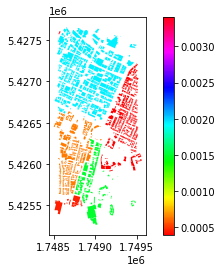

In [10]:
%%time
# load data
gdf_polygon = load_data("buildings_raw.shp", 1748570, 5425500, 1749500, 5427600) # small
# gdf_polygon = load_data("buildings_raw.shp", 1740508, 5420049, 1755776, 5443033) # whole
gdf_polygon.plot(column='IgnProb_bl', cmap='hsv', legend=True)

In [26]:
%%time
# @jit
def edges_creation_Dask(geodataframe, nCores):

  # create list of sources & geometry
  sourceID = dd.from_array(np.repeat(np.array(geodataframe.TARGET_FID), len(geodataframe)))
  sourceID_geometry = dd.from_array(np.repeat(np.array(geodataframe.geometry), len(geodataframe)))
  sourceID_X = dd.from_array(np.repeat(np.array(geodataframe.X), len(geodataframe)))
  sourceID_Y = dd.from_array(np.repeat(np.array(geodataframe.Y), len(geodataframe)))

  # create list of targets & geometry
  targetID = [geodataframe.TARGET_FID] * len(geodataframe)
  targetID = dd.from_array(np.hstack(targetID))
  targetID_geometry = [geodataframe.geometry] * len(geodataframe)
  targetID_geometry = dd.from_array(np.hstack(targetID_geometry))
  targetID_X = [geodataframe.X] * len(geodataframe)
  targetID_X = dd.from_array(np.hstack(targetID_X))
  targetID_Y = [geodataframe.Y] * len(geodataframe)
  targetID_Y = dd.from_array(np.hstack(targetID_Y))

  # concatenate data in dask dataframe
  data = [sourceID,sourceID_geometry,sourceID_X,sourceID_Y,targetID, targetID_geometry, targetID_X, targetID_Y] 

  ddf = dd.concat(data, axis=1)

  ddf.columns = ['source', 'source_geometry', 'source_X', 'source_Y',
                 'target', 'target_geometry', 'target_X', 'target_Y']


  ddf['distance'] = np.sqrt((ddf.target_X-ddf.source_X)**2+(ddf.target_Y-ddf.source_Y)**2)

  # filter on distance
  ddf = ddf[ddf.distance < 50]
  ddf = ddf[ddf.distance != 0]

  # create bearing
  ddf['azimuth'] = np.degrees(np.arctan2((ddf.target_Y-ddf.source_Y), (ddf.target_X-ddf.source_X)))
  ddf['bearing'] = (ddf['azimuth'] + 360) % 360


  # ddf_frame = ddf[(ddf.distance < 50) & (ddf.distance != 0)].compute()

  return ddf

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 11.4 µs


In [27]:
%%time
edges = edges_creation_Dask(gdf_polygon, 4)

CPU times: user 825 ms, sys: 8.09 ms, total: 833 ms
Wall time: 820 ms


In [0]:
edges = dask.delayed(edges)